Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import dump
from pqdm.threads import pqdm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

Read data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv")
data = data[['price', 'zip_code', 'living_space', 'rooms', 'type']]
plz  = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/plz_data.csv") 

Convert types into dummies

In [3]:
type_columns = "type_" + data["type"].unique()
data = pd.get_dummies(data, columns=["type"])
#data = data.drop(columns = "type")

Merge our cols with plz data

In [4]:
data = data.merge(plz, how = 'inner', left_on = "zip_code", right_on = "PLZ")
data = data.drop(columns = ["PLZ", "zip_code"])

print(len(data))
data

13069


,price,living_space,rooms,type_attic-flat,type_attic-room,type_castle,type_chalet,type_detached-house,type_detached-secondary-suite,type_duplex-maisonette,...,PLZ_Group_9000,PLZ_Group_9100,PLZ_Group_9200,PLZ_Group_9300,PLZ_Group_9400,PLZ_Group_9500,PLZ_Group_9600,PLZ_Group_9700,PLZ_Group_9800,PLZ_Group_9900
0,1150000.0,100.0,3.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1420000.0,156.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1430000.0,154.0,4.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,550000.0,124.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,720000.0,93.0,2.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13064,895000.0,130.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13065,1090000.0,147.0,5.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13066,2750000.0,385.0,7.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13067,1415000.0,150.0,6.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


See amount of na's

In [5]:
data.isna().sum().sort_values(ascending = False)

living_space                         1065
price                                1011
rooms                                 582
PLZ_Group_9800                          0
PLZ_Group_4100                          0
                                     ... 
NoisePollutionRailwayL                  0
gde_politics_fdp                        0
gde_social_help_quota                   0
gde_area_nonproductive_percentage       0
PLZ_Group_9900                          0
Length: 162, dtype: int64

Drop NA, since there arent many

In [6]:
data = data.dropna()
len(data)

10931

Select X and y

In [7]:
y_cols = data.columns[0]
X_cols = data.columns[1:]

X = data[X_cols].values
y = data[y_cols].values

X.shape

(10931, 161)

In [8]:
poly = PolynomialFeatures(2).fit(X)
X = poly.transform(X)

Split train and test data

In [9]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, random_state=420)

In [10]:
alphas = np.linspace(800, 850, 5)

scores_alpha = []
for alpha in tqdm(alphas):
    model = Ridge(alpha = alpha).fit(X_train, y_train)
    scores_alpha.append(mean_absolute_percentage_error(model.predict(X_test), y_test))
scores_alpha = np.array(scores_alpha)

100%|██████████| 5/5 [00:42<00:00,  8.40s/it]


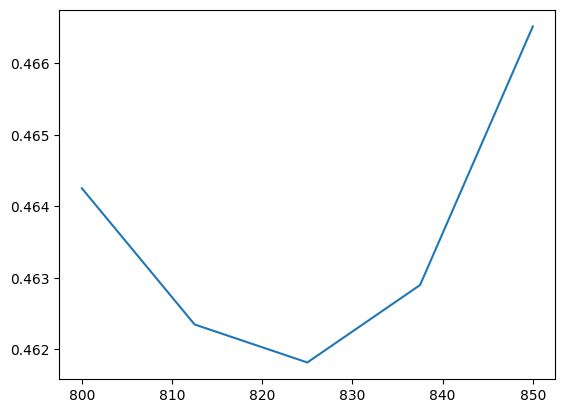

In [11]:
plt.plot(alphas, scores_alpha)

In [12]:
alpha = alphas[scores_alpha.argmin()]
alpha

825.0

Train model and get R2

In [13]:
model = Ridge(alpha = 1700).fit(X_train, y_train)
score = np.round(model.score(X_test, y_test), 3)
print(f'R2 score: {score}')

R2 score: 0.679


Get score (MAPE)

In [14]:
model = Ridge(alpha = alpha).fit(X_train, y_train) # alpha = 395
mean_absolute_percentage_error(model.predict(X_test), y_test)

0.46181359415395573

Plot predicted to real values

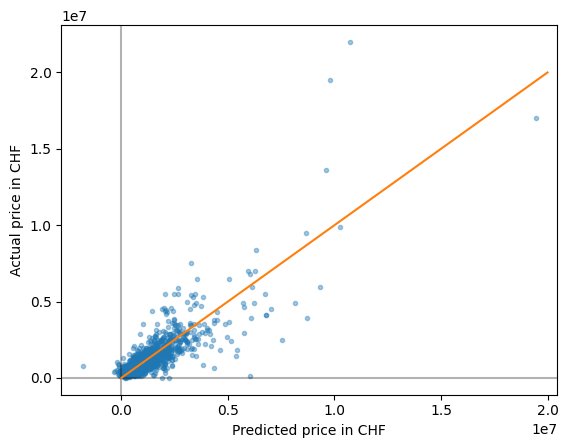

In [15]:
perf = np.linspace(0, 2 * 10 ** 7, 2)
pred = model.predict(X_test)
plt.plot(pred, y_test, '.', alpha = 0.4)
plt.axvline(0, color = 'black', alpha = 0.3)
plt.axhline(0, color = 'black', alpha = 0.3)
plt.xlabel("Predicted price in CHF")
plt.ylabel("Actual price in CHF")
plt.xlim(pred.min() - 10 ** 6, pred.max() + 10 ** 6)
plt.plot(perf, perf)
plt.show()

Make example prediction

In [16]:
pred = pd.DataFrame({"zip_code": [8050], "living_space": [90], "rooms": [4.5], "type": ["flat"]})

if ("type_" + pred.iloc[0]["type"] not in type_columns):
    raise Exception("ALARM")

pred[type_columns] = 0
pred["type_" + pred["type"]] = 1

pred = pred.merge(plz, how = 'inner', left_on = "zip_code", right_on = "PLZ")
pred = pred[X_cols]

pred = poly.transform(pred)
pred = scaler.transform(pred)

print(str(np.round(model.predict(pred)[0], 2)) + " CHF")

1366131.01 CHF


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Dump model to file

In [17]:
dump(model, 'ridge_regression.joblib')

['ridge_regression.joblib']